#### Importing packages

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

#### Read data and take a look at the dataset

In [20]:
df=pd.read_csv("df_new.csv")

In [3]:
df.head()

,Unnamed: 0,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,...,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,...,0,0,1,0,0,1,1,0,0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,...,0,0,1,0,0,1,1,0,0,0
2,2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,...,0,0,0,1,1,0,1,0,0,0
3,3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00,...,1,0,0,0,1,0,1,0,0,0
4,4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,...,0,0,1,0,0,1,1,0,0,0


In [4]:
df.columns

Index(['Unnamed: 0', 'step', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'isFraud', 'errorBalanceOrig',
       'errorBalanceDest', 'day', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'CC', 'CM', 'quartile1', 'quartile2', 'quartile3',
       'quartile4'],
      dtype='object')

#### Set X and Y

In [21]:
X=df[['amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'isFraud', 'errorBalanceOrig',
       'errorBalanceDest', 'day', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'CC', 'CM']]
Y=df["isFraud"]


#### Create training and testing sets

In [22]:
SEED=42

x_train, x_test, y_train, y_test = train_test_split(X, Y,
test_size= 0.2,
random_state= SEED)

### Isolation Forest

In [23]:
ISO=IsolationForest(random_state=42)


#### Fit model to training data

In [24]:
ISO.fit(x_train)

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

#### Make Predictions on test data

In [25]:
ISOtest_pred=ISO.predict(x_test)

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


#### Transform the output of predicted outliers so it matches the isFraud response so we can institute performance metrics

In [26]:
ISO_testpred=[0 if x==1 else 1 for x in ISOtest_pred]

#### Make sure output was transformed correctly

In [27]:
np.unique(ISO_testpred, return_counts=True)

(array([0, 1]), array([1145305,  127219], dtype=int64))

In [28]:
print(y_test.value_counts())

0    1270904
1       1620
Name: isFraud, dtype: int64


In [29]:
print(classification_report(y_test,ISO_testpred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1270904
           1       0.01      0.61      0.02      1620

    accuracy                           0.90   1272524
   macro avg       0.50      0.75      0.48   1272524
weighted avg       1.00      0.90      0.95   1272524



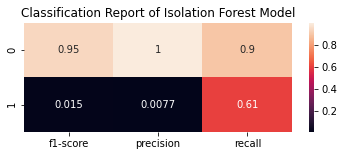

In [31]:


clf_report = classification_report(y_test, ISO_testpred, output_dict=True)
df = pd.DataFrame(clf_report).iloc[:-1, :2].T

fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df, annot=True)
plt.title("Classification Report of Isolation Forest Model")
ax.set_ylim(len(df)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()


#### Testing for overfitting

In [32]:
ISOtr=ISO.predict(x_train)

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [33]:
train_pred=[0 if x==1 else 1 for x in ISOtr]

In [34]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95   5083503
           1       0.01      0.62      0.02      6593

    accuracy                           0.90   5090096
   macro avg       0.50      0.76      0.48   5090096
weighted avg       1.00      0.90      0.95   5090096



#### We do not suspect any overfitting on the data since the training accuracy and recall are very close to that of the testing

### Isolation Forest with Scaling 

In [35]:
scaler=MinMaxScaler()

In [36]:
xtrSC=scaler.fit_transform(x_train)
xteSC=scaler.transform(x_test)

In [37]:
ISOsc=IsolationForest(random_state=42)

In [38]:
ISOsc.fit(xtrSC)

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [39]:
y_predSC=ISOsc.predict(xteSC)

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [40]:
SC_testpred=[0 if x==1 else 1 for x in y_predSC]

In [41]:
print(classification_report(y_test,SC_testpred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1270904
           1       0.01      0.60      0.02      1620

    accuracy                           0.90   1272524
   macro avg       0.50      0.75      0.48   1272524
weighted avg       1.00      0.90      0.95   1272524



Lower than previous model so I will stick with that one